# Problem 1 Multimodal Image–Audio Digit Classification under Noisy Conditions

In this notebook, I provide the solutions to the problem 1 of the NORA Summer School exam.

The sections are as follows:


## Image-Only Classification

- A simple CNN with two convolutional layers and pooling layers.

## Audio-Only Classification

- A simple MLP with two fully connected layers. ??

## Unimodal Performance Comparison

## Multi-Modal Fusion Overview

## Fusion Strategy 1 Multi-Modal Model

## Fusion Strategy 2 Multi-Modal Model

## Representation Visualization

- Visualize the fused representations using PCA or t-SNE.





# Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(device)

mps


# Load Datasets

 train images : torch.Size([17560, 1, 28, 28]) torch.float32
 train img lbl: torch.Size([17560]) torch.int64
 train audio  : torch.Size([17560, 1, 8000]) torch.float64
 train aud lbl: torch.Size([17560]) torch.int64
  test images : torch.Size([5859, 1, 28, 28]) torch.float32
  test img lbl: torch.Size([5859]) torch.int64
  test audio  : torch.Size([5859, 1, 8000]) torch.float64
  test aud lbl: torch.Size([5859]) torch.int64


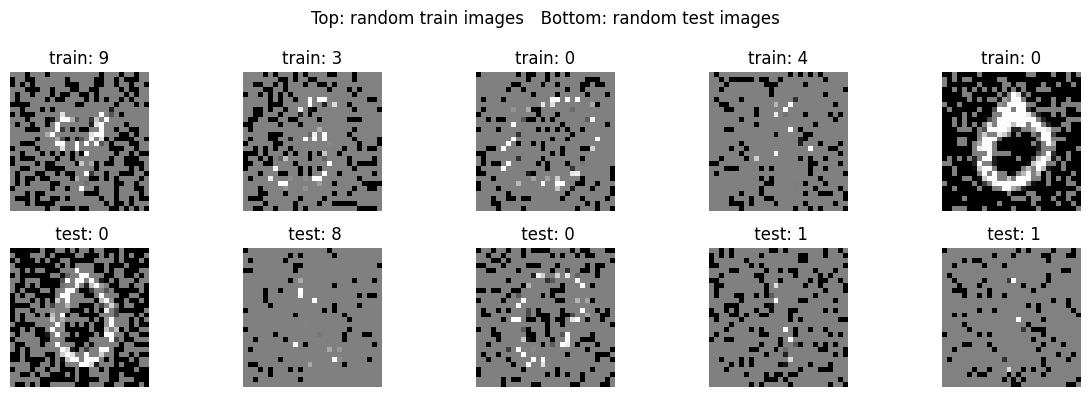

 one train-audio sample: torch.Size([1, 8000]) torch.float64


In [ ]:
train_imgs   = torch.load('data/training_images.pth', weights_only=False)          
train_img_lbl = torch.load('data/training_images_labels.pth', weights_only=False)  
train_audio  = torch.load('data/training_audio.pth', weights_only=False)           
train_aud_lbl = torch.load('data/training_audio_labels.pth', weights_only=False)   

test_imgs    = torch.load('data/test_images.pth', weights_only=False)              
test_img_lbl  = torch.load('data/test_images_labels.pth', weights_only=False)      
test_audio   = torch.load('data/test_audio.pth', weights_only=False)               
test_aud_lbl  = torch.load('data/test_audio_labels.pth', weights_only=False)       

print(" train images :", train_imgs.shape, train_imgs.dtype)
print(" train img lbl:", train_img_lbl.shape, train_img_lbl.dtype)
print(" train audio  :", train_audio.shape, train_audio.dtype)
print(" train aud lbl:", train_aud_lbl.shape, train_aud_lbl.dtype)

print("  test images :", test_imgs.shape, test_imgs.dtype)
print("  test img lbl:", test_img_lbl.shape, test_img_lbl.dtype)
print("  test audio  :", test_audio.shape, test_audio.dtype)
print("  test aud lbl:", test_aud_lbl.shape, test_aud_lbl.dtype)

# 3) PLOT 5 RANDOM TRAIN + 5 RANDOM TEST IMAGES
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
    # train
    idx_t = torch.randint(0, len(train_imgs), (1,)).item()
    axes[0, i].imshow(train_imgs[idx_t,0], cmap='gray')
    axes[0, i].set_title(f"train: {train_img_lbl[idx_t].item()}")
    axes[0, i].axis('off')
    # test
    idx_te = torch.randint(0, len(test_imgs), (1,)).item()
    axes[1, i].imshow(test_imgs[idx_te,0], cmap='gray')
    axes[1, i].set_title(f" test: {test_img_lbl[idx_te].item()}")
    axes[1, i].axis('off')

plt.suptitle("Top: random train images Bottom: random test images")
plt.tight_layout()
plt.show()

print(" one train-audio sample:", train_audio[0].shape, train_audio.dtype)

In [31]:
mean = train_imgs.mean()
std = train_imgs.std()
print(f"mean={mean:.4f}, std={std:.4f}")

mean=-0.7350, std=2.6681


# Dataloaders

In [84]:

mean = -0.7
std = 2.7 

train_img_transforms = transforms.Compose([
    transforms.RandomRotation(15),                           
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.Normalize((mean,), (std,)),             
])

test_img_transforms = transforms.Compose([
    transforms.Normalize((mean,), (std,)),
])

train_audio = train_audio.float()
test_audio  = test_audio.float()

train_aud_ds = TensorDataset(train_audio, train_aud_lbl)
test_aud_ds  = TensorDataset(test_audio,  test_aud_lbl)

class ImageDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs      = imgs     # Tensor [N,1,28,28]
        self.labels    = labels   # Tensor [N]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = self.imgs[idx]        # still a Tensor
        lbl   = self.labels[idx].item()
        if self.transform:
            img = self.transform(img)
        return img, lbl

train_img_ds = ImageDataset(train_imgs, train_img_lbl, transform=train_img_transforms)
test_img_ds  = ImageDataset(test_imgs, test_img_lbl,  transform=test_img_transforms)

# for fusion
class PairedDataset(Dataset):
    def __init__(self, imgs, audios, labels, transform=None):
        """
        imgs:   Tensor[N,1,28,28]
        audios: Tensor[N,1,8000]
        labels: Tensor[N]
        """
        print("PairedDataset: imgs, audios, labels shapes:", imgs.shape, audios.shape, labels.shape)
        assert len(imgs) == len(audios) == len(labels)
        self.imgs   = imgs
        self.audios = audios
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img   = self.imgs[idx]       # still a Tensor [1,28,28]
        if self.transform:
            img = self.transform(img)
        return (img, self.audios[idx]), self.labels[idx]

train_fused_ds = PairedDataset(train_imgs, train_audio, train_img_lbl, transform=train_img_transforms)
test_fused_ds  = PairedDataset(test_imgs,  test_audio,  test_img_lbl, transform=test_img_transforms)

batch_size = 64

# Image-only loaders
train_img_loader = DataLoader(train_img_ds, batch_size=batch_size, shuffle=True)
test_img_loader  = DataLoader(test_img_ds,  batch_size=batch_size, shuffle=False)
# Audio-only loaders
train_aud_loader = DataLoader(train_aud_ds, batch_size=batch_size, shuffle=True)
test_aud_loader  = DataLoader(test_aud_ds,  batch_size=batch_size, shuffle=False)
# Fused (image+audio) loaders
train_fused_loader = DataLoader(train_fused_ds, batch_size=batch_size, shuffle=True)
test_fused_loader  = DataLoader(test_fused_ds,  batch_size=batch_size, shuffle=False)

PairedDataset: imgs, audios, labels shapes: torch.Size([17560, 1, 28, 28]) torch.Size([17560, 1, 8000]) torch.Size([17560])
PairedDataset: imgs, audios, labels shapes: torch.Size([5859, 1, 28, 28]) torch.Size([5859, 1, 8000]) torch.Size([5859])


## View Loaders

### Train Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5162463..3.975541].


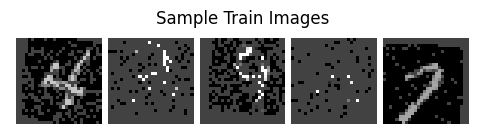

Labels for these images: [4, 2, 9, 9, 7]
Test batch — images tensor shape: torch.Size([64, 1, 28, 28])
Test batch — labels tensor shape: torch.Size([64])


In [ ]:
# Visualize a few training images
imgs, labels = next(iter(train_img_loader))

grid = torchvision.utils.make_grid(imgs[:5], nrow=5, normalize=False, pad_value=1)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Train Images")
plt.axis('off')
plt.show()

print("Labels for these images:", labels[:5].tolist())

test_imgs2, test_lbls = next(iter(test_img_loader))
print(f"Test batch — images tensor shape: {test_imgs2.shape}")
print(f"Test batch — labels tensor shape: {test_lbls.shape}")

Audio batch shape: torch.Size([64, 1, 8000])
Audio Labels shape: torch.Size([64])


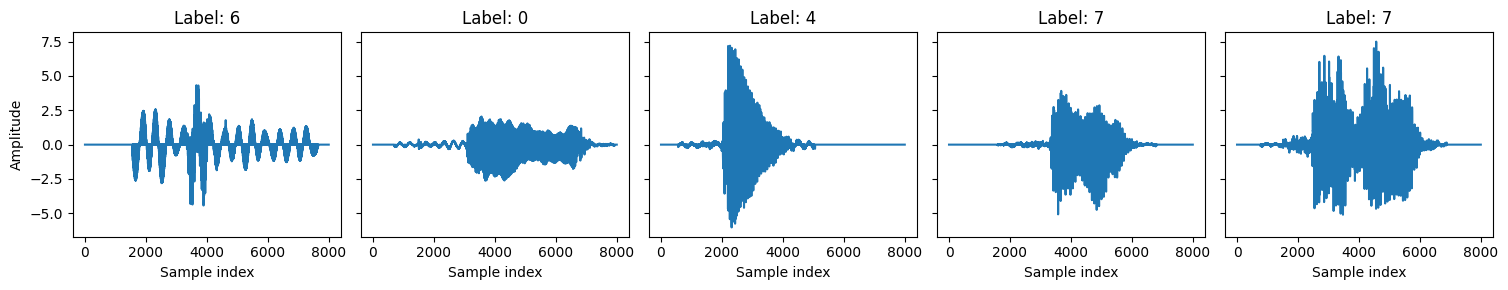

Labels for these audio: [6, 0, 4, 7, 7]


In [79]:
# Visualize a few training audio
audio, labels = next(iter(train_aud_loader)) # audio: Tensor[64,1,8000], labels: Tensor[64]

print("Audio batch shape:", audio.shape)
print("Audio Labels shape:", labels.shape)

audio = audio.cpu().numpy()
labels = labels.cpu().numpy()

# set up a 1×5 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=True)

for i in range(5):
    ax = axes[i]
    # audio[i, 0] is shape (8000,)
    ax.plot(audio[i, 0])
    ax.set_title(f"Label: {labels[i]}")
    ax.set_xlabel("Sample index")
    if i == 0:
        ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

print("Labels for these audio:", labels[:5].tolist())


In [24]:
type(train_img_ds)
type(train_img_loader)

torch.utils.data.dataloader.DataLoader

### Test Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8394642..1.3493654].


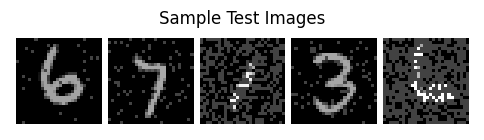

Labels for these images: [6, 7, 1, 3, 6]


In [72]:
imgs, labels = next(iter(test_img_loader))

grid = torchvision.utils.make_grid(imgs[:5], nrow=5, normalize=False, pad_value=1)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Test Images")
plt.axis('off')
plt.show()

print("Labels for these images:", labels[:5].tolist())

Audio batch shape: torch.Size([64, 1, 8000])
Audio Labels shape: torch.Size([64])


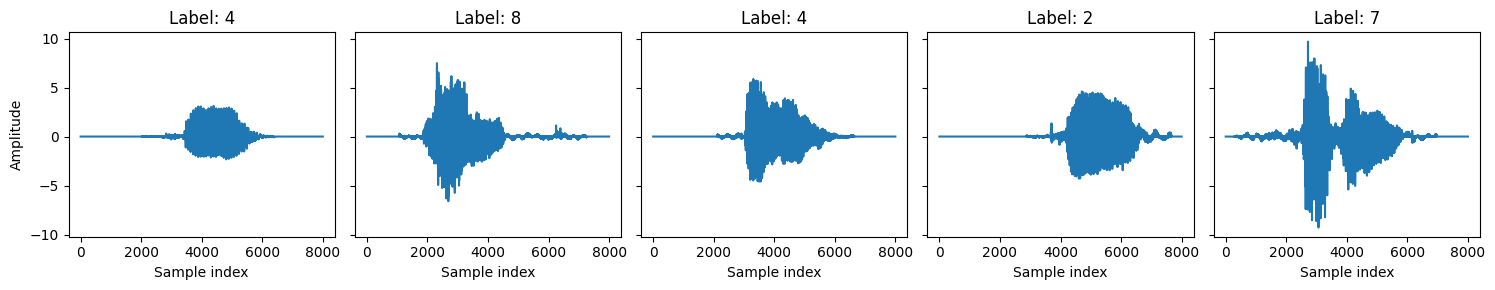

Labels for these audio: [4, 8, 4, 2, 7]


In [83]:
# Visualize a few training audio
audio, labels = next(iter(test_aud_loader)) # audio: Tensor[64,1,8000], labels: Tensor[64]

print("Audio batch shape:", audio.shape)
print("Audio Labels shape:", labels.shape)

audio = audio.cpu().numpy()
labels = labels.cpu().numpy()

# set up a 1×5 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=True)

for i in range(5):
    ax = axes[i]
    # audio[i, 0] is shape (8000,)
    ax.plot(audio[i, 0])
    ax.set_title(f"Label: {labels[i]}")
    ax.set_xlabel("Sample index")
    if i == 0:
        ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

print("Labels for these audio:", labels[:5].tolist())

### Fused Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1598865..1.6784049].


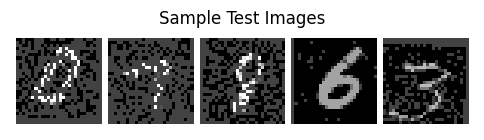

Labels for these images: [0, 7, 8, 6, 3]


In [ ]:
(imgs, audio), labels = next(iter(train_fused_loader))

grid = torchvision.utils.make_grid(imgs[:5], nrow=5, normalize=False, pad_value=1)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Test Images")
plt.axis('off')
plt.show()

print("Labels for these images:", labels[:5].tolist())

# Define our models - a CNN, an MLP, and a FusedModel

In [ ]:
class CNNEncoder(nn.Module):
    """Simple CNN Encoder"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 10) #This shape depends on the kernels and the input (split) shape

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

class MLP(nn.Module):
    """Simple 2-Layer MLP"""
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x.view(x.size(0), -1))) #Flatten all dimensions except batch_size
        x = F.relu(self.fc2(x))
        return x

# Fusing representations
class FusedModel(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel, self).__init__()
        # FILL IN HERE

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # FILL IN HERE

# Utils

In [ ]:
import torch.nn.functional as F

def prepare_data(data):
    """Splits MNIST images into two halves horizontally and pads to original shape."""
    upper_half = data[:, :, :14, :]  # Top half: [B, 1, 14, 28]
    lower_half = data[:, :, 14:, :]  # Bottom half: [B, 1, 14, 28]

    # Pad bottom 14 rows with zeros for upper_half
    upper_half_padded = F.pad(upper_half, pad=(0, 0, 0, 14))  # Pad rows: (left, right, top, bottom)

    # Pad top 14 rows with zeros for lower_half
    lower_half_padded = F.pad(lower_half, pad=(0, 0, 14, 0))  # Pad rows: (left, right, top, bottom)

    return upper_half_padded, lower_half_padded


def train_model(model: nn.Module, data_loader, optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss):
    """Train the model."""
    # FILL IN HERE


def evaluate_model(model: nn.Module, data_loader, criterion):
    """Evaluate the model."""
    # FILL IN HERE (compute validation and test loss and accuracy)


In [ ]:
for images, _ in train_loader:
  upper_half, lower_half = prepare_data(images)
  print(upper_half.shape, lower_half.shape)
  print(images.shape)
  break

# Init and train CNN

In [ ]:
#Initialize CNN
cnn_encoder = CNNEncoder()
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_encoder.parameters(), lr=learning_rate)

In [ ]:
# Train and evaluate the CNN encoder
for epoch in range(num_epochs):
    train_model(cnn_encoder, train_loader, cnn_optimizer, criterion)
    print(f"Epoch {epoch+1}: CNN Encoder val loss {evaluate_model(cnn_encoder, val_loader, criterion)}")

print("Done training! Evaluating on test set...")
#Test
evaluate_model(cnn_encoder, test_loader, criterion)

# Init and train MLP

In [ ]:
#Initialize MLP
mlp = MLP()
criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# Train and evaluate the MLP
for epoch in range(num_epochs):
    train_model(mlp, train_loader, mlp_optimizer, criterion)
    print(f"Epoch {epoch+1}: MLP val loss {evaluate_model(mlp, val_loader, criterion)}")

print("Done training! Evaluating on test set...")
#Test
evaluate_model(mlp, test_loader, criterion)

# Init and train FusedModel

In [ ]:
#Initialize Fusion Encoder
fused_nn = FusedModel()
criterion = nn.CrossEntropyLoss()
fuse_optimizer =  optim.Adam(fused_nn.parameters(), lr=learning_rate)

In [ ]:
# Train and evaluate the Fused encoder
for epoch in range(num_epochs):
    train_model(fused_nn, train_loader, fuse_optimizer, criterion)
    print(f"Epoch {epoch+1}: Fusion Encoder val loss {evaluate_model(fused_nn, val_loader, criterion)}")

print("Done training! Evaluating on test set...")
#Test
evaluate_model(fused_nn, test_loader, criterion)

## (iv) Different Fusion Stategies
